# Assessment 3: RNNs for stock price prediction

In [1]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [2]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


Using device: cpu



## Step01: Data exploration

In [4]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[26696:MainThread](2023-11-22 11:20:54,761) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[26696:MainThread](2023-11-22 11:20:54,768) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[26696:MainThread](2023-11-22 11:20:54,770) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [5]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['^GSPC']
    # index_list  = ['AAPL']
    # fields = ['$close', '$volume', '$open', '$high', '$low']
    fields = ['$close', '$high', '$low', '$volume', '$open']
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    # df.columns = ['symbols','date','close','volume','open','high','low']
    df.columns = ['symbols','date','close','high','low','volume','open']
    df = df.drop(columns='symbols')
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    df = df.set_index(['date'])
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
    df = df.rename(columns={'close': 'value'})
    return df, index_list

df_all, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [6]:
df_all.tail(5)

,value,high,low,volume,open
date,,,,,
2020-11-04,2.343672,2.372809,2.317625,7.027481e+12,2.318503
2020-11-05,2.389280,2.401940,2.372462,7.112918e+12,2.372462
2020-11-06,2.388593,2.396856,2.371509,7.102281e+12,2.387844
2020-11-09,2.416539,2.481531,2.414484,1.257180e+13,2.438686
2020-11-10,2.413157,2.421113,2.390274,8.851100e+12,2.411611


### Exploratory Image analysis and feature engineering

In [7]:
# features: lagging
def generate_time_lags(df, period):
    df_n = df.copy()
    # for n in range(1, n_lags + 1):
    for n in period:
        df_n[f"lag{n}"] = df_n["value"].shift(n)
        df_n[f"lag_res{n}"] = df_n["value"] - df_n[f"lag{n}"]
        # del df_n[f"lag{n}"]
    df_n = df_n.iloc[max(period):]
    return df_n

# features: encode the day features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, onehot_columns):
    ct = ColumnTransformer(
        [('onehot', OneHotEncoder(drop='first'), onehot_columns)],
        remainder='passthrough'
        )
    return ct.fit_transform(df)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
    
    return pd.concat([df, dummies], axis=1).drop(columns=cols)

# features: holidays
from datetime import date
import holidays

us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

# combine feature
def add_feature(df):
    df = (
                df
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year=df.index.isocalendar().week)
              )
    
    # calculator the indicator
    ## RSI
    delta = df.value.diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    # Calculate the average gain and the average loss
    avg_gain = up.rolling(window=14).mean()
    avg_loss = abs(down.rolling(window=14).mean())
    RS = avg_gain / avg_loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    df['RSI'] = RSI
    
    ## the Stochastic Oscillator
    low_min  = df.low.rolling(window=14).min()
    high_max = df.high.rolling(window=14).max()
    df['Stochastic'] = 100 * (df.value - low_min) / (high_max - low_min)
    
    # short-term exponential moving average (EMA)
    ShortEMA = df.value.ewm(span=12, adjust=False).mean()

    # Calculate the long-term EMA
    LongEMA = df.value.ewm(span=26, adjust=False).mean()

    # Calculate the MACD line
    MACD = ShortEMA - LongEMA

    # Calculate the signal line
    signal = MACD.ewm(span=9, adjust=False).mean()

    # Add the MACD and Signal line to the DataFrame
    df['MACD'] = MACD
    df['Signal_Line'] = signal
    
    
    df = generate_time_lags(df, [1,7,14,30,60,90,180])    
    df = add_holiday_col(df, us_holidays)
    df = onehot_encode_pd(df, ['month','day','day_of_week','week_of_year'])
    # df = onehot_encode_pd(df, ['month','day','day_of_week'])
    
    # predict residual
    df['price'] = df.value
    df.value = df.lag_res1
    del df["lag_res1"]
    del df["high"]
    del df["low"]
    return df

df_feature = add_feature(df_all)
df_feature

,value,volume,open,RSI,Stochastic,MACD,Signal_Line,lag1,lag7,lag_res7,...,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,price
date,,,,,,,,,,,,,,,,,,,,,
2000-09-18,-0.014497,1.414153e+12,0.997659,23.703781,2.937513,-0.002804,0.001996,0.997659,1.022637,-0.039476,...,0,0,0,0,0,0,0,0,0,0.983162
2000-09-19,0.010475,1.505834e+12,0.983162,32.592092,20.392450,-0.003797,0.000838,0.983162,1.017186,-0.023549,...,0,0,0,0,0,0,0,0,0,0.993636
2000-09-20,-0.005826,1.622052e+12,0.993636,32.297087,20.566838,-0.004996,-0.000329,0.993636,1.013619,-0.025809,...,0,0,0,0,0,0,0,0,0,0.987810
2000-09-21,-0.001559,1.624109e+12,0.987810,23.993960,18.257087,-0.006003,-0.001464,0.987810,1.008671,-0.022420,...,0,0,0,0,0,0,0,0,0,0.986252
2000-09-22,-0.000225,1.741796e+12,0.986252,22.114750,27.141244,-0.006742,-0.002520,0.986252,1.010659,-0.024632,...,0,0,0,0,0,0,0,0,0,0.986027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,0.050556,7.027481e+12,2.318503,46.424836,74.338175,-0.008091,-0.003433,2.293115,2.314766,0.028906,...,1,0,0,0,0,0,0,0,0,2.343672
2020-11-05,0.045609,7.112918e+12,2.372462,52.132709,93.697253,-0.000269,-0.002800,2.343672,2.307762,0.081518,...,1,0,0,0,0,0,0,0,0,2.389280
2020-11-06,-0.000688,7.102281e+12,2.387844,57.255415,93.354921,0.005808,-0.001079,2.389280,2.226326,0.162266,...,1,0,0,0,0,0,0,0,0,2.388593


In [8]:
print(f"the maxmimum date: {max(df_all.index)} with period of 5 years")
df = df_feature[df_feature.index.year >= 2007] # 2015
print(f"so the period will filter since {min(df.index)} to {max(df.index)}")

the maxmimum date: 2020-11-10 00:00:00 with period of 5 years
so the period will filter since 2007-01-03 00:00:00 to 2020-11-10 00:00:00


## Step 02: Data splitting

In [9]:
# splitting criteria training 70%, validation 20% and testing 10%

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def split_data(df, target_col, split_period = True):
    
    ################################# NOTE #################################
    #  Split the data based o the 5 years period #
    #  Training set: since 2016 to 2018: around 3 years #
    #  Validation set: since 2019: around 1 years #
    #  Testing set: on 2020: around 1 years #
    ########################################################################
    
    # set up the total period
    period = 2015
    df = df[(df.index.year >= period) & (df.index.year <= 2019)]
    # df = df[(df.index.year >= 2020) & (df.index.year <= 2020)]
    print(f"so the period will filter since {min(df_feature.index)} to {max(df_feature.index)}")
    
    if split_period:
        # split by period
        train_data = df[df.index.year <= period + 2]
        valid_data = df[(df.index.year >= period + 3) & (df.index.year <= period + 3)]
        test_data = df[(df.index.year >= period + 4) & (df.index.year <= period + 4)]
        
        # def change_to_datepd(date):
        #     return pd.Timestamp(date)
        
        # # split by period - month
        # train_data = df[df.index <= change_to_datepd(date(2020,6,30))]
        # valid_data = df[(df.index >= change_to_datepd(date(2020,7,1))) & (df.index <= change_to_datepd(date(2020,9,30)))]
        # test_data = df[(df.index >= change_to_datepd(date(2020,10,1))) & (df.index <= change_to_datepd(date(2020,12,31)))]
    else:
        # split by ratio
        train_size = int(len(df) * 0.7)
        valid_size = int(len(df) * 0.2)
        
        train_data = df[:train_size]
        valid_data = df[train_size:train_size + valid_size]
        test_data = df[train_size + valid_size:]
    

    
    print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")
    
    x_train, y_train = feature_label_split(train_data, target_col)
    x_valid, y_valid = feature_label_split(valid_data, target_col)
    x_test, y_test = feature_label_split(test_data, target_col)
    
    # return train_data,valid_data, test_data
    return x_train, y_train, x_valid, y_valid, x_test, y_test, df
    
    
# train_size = int(len(df) * 0.7)
# valid_size = int(len(df) * 0.2)

# train_data = df[:train_size]
# valid_data = df[train_size:train_size + valid_size]
# test_data = df[train_size + valid_size:]

# print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")

X_train, y_train, X_val, y_val, X_test, y_test, df_feature = split_data(df_feature, 'value')
y_test.head(5)

so the period will filter since 2000-09-18 00:00:00 to 2020-11-10 00:00:00
Training size: 755 period 2015-01-02 00:00:00 to 2017-12-29 00:00:00 
Validation size: 251 period 2018-01-02 00:00:00 to 2018-12-31 00:00:00
test_data size: 252 period 2019-01-02 00:00:00 to 2019-12-31 00:00:00


,value
date,
2019-01-02,0.002164
2019-01-03,-0.042294
2019-01-04,0.057206
2019-01-07,0.012081
2019-01-08,0.016825


In [10]:
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.graph_objs import Figure

def plot_dataset(df, yaxis, title , yaxis_name, period):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df[yaxis],
        mode="lines",
        name=yaxis_name,
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    
    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title=yaxis_name, ticklen=5, zeroline=False),
    )

    # Create a Figure object from the data and layout
    fig = Figure(data=data, layout=layout)
    # Add a vertical line if vline_x is specified
    if period is not None:
        # validation period
        fig.add_vrect(x0 = period[0], x1 = period[1], line_width=3, fillcolor="blue", opacity=0.2)
        # testing period
        fig.add_vrect(x0 = period[1], x1 = max(df.index), line_width=3, fillcolor="green", opacity=0.2)
        
    fig.add_annotation(
        xref="x domain",
        yref="y domain",
        # The arrow head will be 25% along the x axis, starting from the left
        x=0.72,
        # The arrow head will be 40% along the y axis, starting from the bottom
        y=0.8,
        text="Validation Period",
        arrowhead=2,
    )
    fig.add_annotation(
        xref="x domain",
        yref="y domain",
        # The arrow head will be 25% along the x axis, starting from the left
        x=0.92,
        # The arrow head will be 40% along the y axis, starting from the bottom
        y=0.8,
        text="Testing Period",
        arrowhead=2,
    )
    iplot(fig)

In [11]:
plot_dataset(df_feature,'value', title='S&P residual price since 2016 to 2020', yaxis_name = 'Residual Prices',period = ['2018-01-01','2019-01-01'])
plot_dataset(df_feature,'price', title='data provide the S&P500 index since starting point', yaxis_name = 'Daily Prices',period = ['2018-01-01','2019-01-01'])

In [12]:
df_feature

,value,volume,open,RSI,Stochastic,MACD,Signal_Line,lag1,lag7,lag_res7,...,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,price
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.000476,3.979757e+12,1.401327,55.359223,70.782703,0.007176,0.006846,1.401327,1.414695,-0.013844,...,0,0,0,0,0,0,0,0,0,1.400851
2015-01-05,-0.025605,5.581857e+12,1.398292,54.185947,39.689137,0.004266,0.006330,1.400851,1.417165,-0.041919,...,0,0,0,0,0,0,0,0,0,1.375246
2015-01-06,-0.012231,6.553016e+12,1.376315,52.906935,24.836780,0.000961,0.005256,1.375246,1.416968,-0.053953,...,0,0,0,0,0,0,0,0,0,1.363015
2015-01-07,0.015852,5.591202e+12,1.365016,61.573649,43.521505,-0.000374,0.004130,1.363015,1.421657,-0.042791,...,0,0,0,0,0,0,0,0,0,1.378867
2015-01-08,0.024666,5.780044e+12,1.382072,60.908071,68.934821,0.000551,0.003415,1.378867,1.422882,-0.019350,...,0,0,0,0,0,0,0,0,0,1.403532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000429,1.904941e+12,2.195304,89.110608,96.452126,0.023579,0.020434,2.194324,2.156747,0.037148,...,0,0,0,0,0,0,0,1,0,2.193895
2019-12-26,0.011250,3.174579e+12,2.196495,89.953150,99.850650,0.024606,0.021269,2.193895,2.172163,0.032983,...,0,0,0,0,0,0,0,1,0,2.205145
2019-12-27,0.000075,3.568324e+12,2.210128,87.671314,93.508118,0.025137,0.022042,2.205145,2.172891,0.032330,...,0,0,0,0,0,0,0,1,0,2.205220


## Step 3: Data Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
 
X_train, y_train, X_val, y_val, X_test, y_test    
    
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [14]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    # return X_output,Y_output
    return torch.utils.data.TensorDataset(X_output, Y_output)

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

batch_size = 1
trainloader = torch.utils.data.DataLoader(
    # torch.utils.data.TensorDataset(X_train, y_train), 
    TensorDataset(train_features, train_targets),
    shuffle=True, 
    batch_size=batch_size,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    TensorDataset(val_features, val_targets),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    # create_dataset(test_data,20),
    TensorDataset(test_features, test_targets),
    batch_size=batch_size,
    shuffle=False,
    pin_memory = True
    )


In [99]:
# check shape
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([1, 74])
torch.Size([1, 1])


## Step 04: Define the RNN Model

### Vanilla RNN

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self._init_weights()
        
    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                nn.init.zeros_(param.data)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

### Long Short-Term Memory (LSTM)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self._init_weights()
        
    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                nn.init.zeros_(param.data)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

### Gated Recurrent Unit (GRU)

In [17]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self._init_weights()
        
    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                nn.init.zeros_(param.data)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

###  BiRNN

In [18]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(BiLSTM, self).__init__()
        
        # Initialize dimensions
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, 
                            batch_first=True, dropout=dropout_prob, bidirectional=True)
        
        # Define the output layer
        # Multiplied by 2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self._init_weights()
        
    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                nn.init.zeros_(param.data)

    def forward(self, x):
        # Initialize hidden state with zeros
        # Multiplied by 2 for bidirectional
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

###  BiGRU

In [19]:
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(BiGRU, self).__init__()
        
        # Initialize dimensions
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # Bidirectional GRU
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, 
                          batch_first=True, dropout=dropout_prob, bidirectional=True)
        
        # Fully connected layer
        # Output size is doubled due to bidirectionality
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self._init_weights()
        
    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name:
                nn.init.zeros_(param.data)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).to(x.device)  # 2 for bidirection
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out


### Get model function

In [20]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel,
        "gru": GRUModel,
        "bilstm": BiLSTM,
        "bigru": BiGRU,
    }
    return models.get(model.lower())(**model_params)

## Step 05: training model

### training function

In [21]:
import time
from tqdm import tqdm

## apply the dataloader
set_seed(1311)

def train_epoch(model, dataloader, criterion, optimizer, n_features = 1):
    model.train()
    
    # Initializing variable
    running_loss = 0.0
    total_train = 0
    
    for inputs, labels in dataloader:
    # for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.view([batch_size, -1, n_features]).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        total_train += labels.size(0)
        
    epoch_loss = running_loss / total_train
    return epoch_loss
    
def evaluate(model, dataloader, criterion, n_features = 1, be_test = False):
    model.eval()
    running_loss = 0.0
    total = 0
    
    # for test set prediction
    predictions = []
    values = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
        # for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.view([batch_size, -1, n_features]).to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs.view(-1), labels)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            if be_test:
                predictions.append(outputs.to(device).detach().numpy())
                values.append(labels.to(device).detach().numpy())
    
    loss = running_loss / total
    if be_test:
        return loss, predictions, values
    return loss

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, input_dim, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./model/{dataset}_{model_name}.pth'
    # print('Model will be saved to:', PATH)
    # print('Using device:', device, 'with seed: 1311')
    # print()

    ## section01: Initialize variables
    best_val_loss = 100000  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'best_model': [],
        'test_pred': [],
        'test_actual': [],
    }
    
     ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss = train_epoch(model, trainloader, criterion, optimizer,input_dim)
        val_loss = evaluate(model, valloader, criterion, input_dim)

        # Step the scheduler with the validation loss
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: Adam lr %f -> %f" % (epoch, before_lr, after_lr))
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Save the model if it has improved on validation accuracy
        if best_val_loss > val_loss:
            # print("check loss: ",best_val_loss,val_loss)
            best_val_loss = val_loss
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')
            
        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    print('Training complete. Evaluating on test set with the best model...')
    
    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    
    test_loss, history['test_pred'] , history['test_actual']  = evaluate(best_model, testloader, criterion, input_dim, True)
    # y_pred, h_State = best_model(torch.tensor(test_data))
    print(f'Test Loss: {test_loss:.4f}')
    # Add test results to history
    history['test_loss'] = test_loss
    history['best_model'] = best_model
    
    return history

def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


### Standard setting

In [22]:
# initial set structure
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 512 # 128
layer_dim = 5 # layer_dim
dropout = 0.2 # 0.2

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout
                }


# initial training hyperparameter
dataset = index_list[0]

learning_rate = 1e-4 # 1e-5
weight_decay = 1e-4
num_epochs = 30 # 50
momentum = 0.9


### Hyperparameter tuning

In [23]:
# import itertools
# import torch.optim as optim

# num_epochs_tuning = 20 # 50
# param_grid = {
#     'learning_rate': [1e-4,1e-5,1e-6],
#     'weight_decay': [1e-4],
#     'hidden_dim': [512],
#     'layer_dim': [5],
#     'dropout': [0.2],
# }

# best_score = float('inf')  # or -float('inf') for accuracy or other metrics where higher is better
# best_params = {
#     'learning_rate': None,
#     'weight_decay': None,
# }

# for learning_rate, weight_decay, hidden_dim, layer_dim, dropout  in itertools.product(
#     param_grid['learning_rate'],
#     param_grid['weight_decay'],
#     param_grid['hidden_dim'],
#     param_grid['layer_dim'],
#     param_grid['dropout'],
# ):
#     # model construct
#     model_params = {'input_dim': input_dim,
#                 'hidden_dim' : hidden_dim,
#                 'layer_dim' : layer_dim,
#                 'output_dim' : output_dim,
#                 'dropout_prob' : dropout
#                 }
#     # model selection
#     model_name = 'rnn'
#     model = get_model(model_name, model_params)
    
#     # optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#     criterion = nn.MSELoss()  # Change depending on your task
    
#     from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
#     scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#     # scheduler = ExponentialLR(optimizer, gamma=0.95)

#     print("This Loop parameter",
#         model_params,
#         {
#         'learning_rate': learning_rate,
#         'weight_decay': weight_decay
#         }
#         )
#     rnn_results = train_network(model,
#                                 optimizer,
#                                 criterion,
#                                 scheduler,
#                                 trainloader,
#                                 valloader,
#                                 testloader,
#                                 num_epochs_tuning,
#                                 input_dim,
#                                 model_name,
#                                 dataset
#                                 )
#     val_score = rnn_results['val_loss'][-1]
#     # Update best score and parameters
#     if val_score < best_score:
#         best_score = val_score
#         best_params = {
#                         'learning_rate': learning_rate,
#                         'weight_decay': weight_decay,
#                         'hidden_dim': hidden_dim,
#                         'layer_dim': layer_dim,
#                         'dropout_prob': dropout,
#                     }
#         print("***Parameters Updated***")
#     print("-"*50)
    
# model_params
        
# print("***Best Score (e.g., lowest loss):", best_score)
# print("***Best Parameters:", best_params)

In [24]:
# learning_rate = best_params['learning_rate']
# learning_rate = 1e-4
# weight_decay = best_params['weight_decay']
# # model construct
# model_params = {'input_dim': input_dim,
#             'hidden_dim' : best_params['hidden_dim'],
#             'layer_dim' : best_params['layer_dim'],
#             'output_dim' : output_dim,
#             'dropout_prob' : best_params['dropout_prob']
#             }
# model_params

### Training with LSTM

Epoch 0: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 1/30, Train Loss: 0.0332, Val Loss: 0.0354, Time: 76.46s
Epoch 1: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 2/30, Train Loss: 0.0109, Val Loss: 0.0322, Time: 73.52s
Epoch 2: Adam lr 0.000100 -> 0.000099
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 3/30, Train Loss: 0.0104, Val Loss: 0.0314, Time: 83.23s
Epoch 3: Adam lr 0.000099 -> 0.000098
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 4/30, Train Loss: 0.0100, Val Loss: 0.0299, Time: 84.14s
Epoch 4: Adam lr 0.000098 -> 0.000098
Epoch 5/30, Train Loss: 0.0095, Val Loss: 0.0305, Time: 78.77s
Epoch 5: Adam lr 0.000098 -> 0.000096
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 6/30, Train Loss: 0.0096, Val Loss: 0.0293, Time: 84.97s
Epoch 6: Adam lr 0.000096 -> 0.000095
Epoch 7/30, Train Loss: 0.0092, Val Loss: 0.0303, Time: 124.52s
Epoch 7: Adam lr 0.000095 -> 0.000094

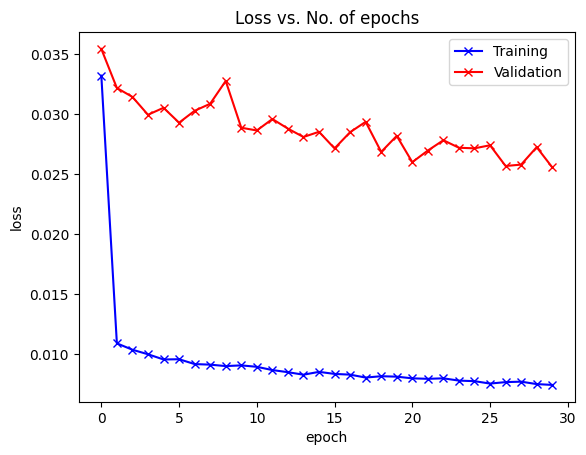

In [27]:
# model selection
model_name = 'lstm'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# scheduler = ExponentialLR(optimizer, gamma=0.95)



lstm_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(lstm_results['train_loss'], lstm_results['val_loss'])

### Training with GRU

Epoch 0: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_gru.pth
Epoch 1/30, Train Loss: 0.0228, Val Loss: 0.0368, Time: 58.13s
Epoch 1: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_gru.pth
Epoch 2/30, Train Loss: 0.0111, Val Loss: 0.0292, Time: 58.46s
Epoch 2: Adam lr 0.000100 -> 0.000099
Epoch 3/30, Train Loss: 0.0102, Val Loss: 0.0358, Time: 57.15s
Epoch 3: Adam lr 0.000099 -> 0.000098
Model improved and saved to ./model/^GSPC_gru.pth
Epoch 4/30, Train Loss: 0.0096, Val Loss: 0.0265, Time: 56.70s
Epoch 4: Adam lr 0.000098 -> 0.000098
Epoch 5/30, Train Loss: 0.0091, Val Loss: 0.0270, Time: 57.10s
Epoch 5: Adam lr 0.000098 -> 0.000096
Epoch 6/30, Train Loss: 0.0091, Val Loss: 0.0273, Time: 59.08s
Epoch 6: Adam lr 0.000096 -> 0.000095
Epoch 7/30, Train Loss: 0.0088, Val Loss: 0.0299, Time: 64.02s
Epoch 7: Adam lr 0.000095 -> 0.000094
Epoch 8/30, Train Loss: 0.0088, Val Loss: 0.0275, Time: 64.17s
Epoch 8: Adam lr 0.000094 -> 0.000092
Epoc

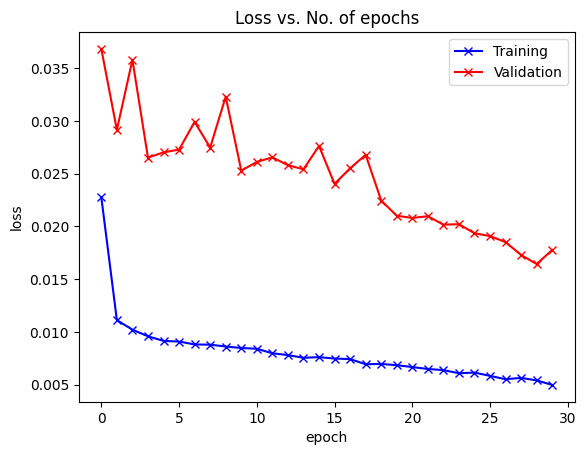

In [28]:
# model selection
model_name = 'gru'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# scheduler = ExponentialLR(optimizer, gamma=0.95)



gru_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(gru_results['train_loss'], gru_results['val_loss'])

### Training with BiLSTM

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_bilstm.pth
Epoch 1/30, Train Loss: 0.0252, Val Loss: 0.0379, Time: 233.74s
Epoch 1: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_bilstm.pth
Epoch 2/30, Train Loss: 0.0113, Val Loss: 0.0335, Time: 206.91s
Epoch 2: Adam lr 0.000100 -> 0.000099
Epoch 3/30, Train Loss: 0.0106, Val Loss: 0.0338, Time: 201.30s
Epoch 3: Adam lr 0.000099 -> 0.000098
Epoch 4/30, Train Loss: 0.0103, Val Loss: 0.0340, Time: 218.59s
Epoch 4: Adam lr 0.000098 -> 0.000098
Model improved and saved to ./model/^GSPC_bilstm.pth
Epoch 5/30, Train Loss: 0.0097, Val Loss: 0.0325, Time: 234.04s
Epoch 5: Adam lr 0.000098 -> 0.000096
Model improved and saved to ./model/^GSPC_bilstm.pth
Epoch 6/30, Train Loss: 0.0093, Val Loss: 0.0323, Time: 206.99s
Epoch 6: Adam lr 0.000096 -> 0.000095
Model improved and saved to ./model/^GSPC_bilstm.pth
Epoch 7/30, Train Loss: 0.0093, Val Loss: 0.0292, Time: 242.74s
Epoch 7: Adam lr 0.00

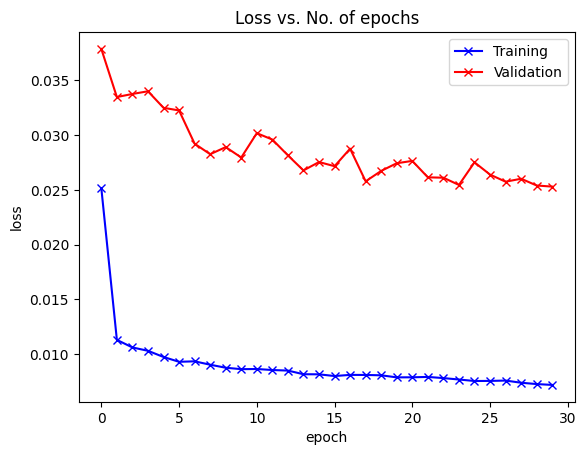

In [64]:
# model selection
model_name = 'bilstm'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# scheduler = ExponentialLR(optimizer, gamma=0.95)



bilstm_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(bilstm_results['train_loss'], bilstm_results['val_loss'])

### Training with BiGRU

Epoch 0: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_bigru.pth
Epoch 1/30, Train Loss: 0.0190, Val Loss: 0.0381, Time: 140.50s
Epoch 1: Adam lr 0.000100 -> 0.000100
Model improved and saved to ./model/^GSPC_bigru.pth
Epoch 2/30, Train Loss: 0.0119, Val Loss: 0.0295, Time: 141.46s
Epoch 2: Adam lr 0.000100 -> 0.000099
Epoch 3/30, Train Loss: 0.0100, Val Loss: 0.0329, Time: 140.87s
Epoch 3: Adam lr 0.000099 -> 0.000098
Model improved and saved to ./model/^GSPC_bigru.pth
Epoch 4/30, Train Loss: 0.0095, Val Loss: 0.0266, Time: 139.87s
Epoch 4: Adam lr 0.000098 -> 0.000098
Epoch 5/30, Train Loss: 0.0093, Val Loss: 0.0281, Time: 140.83s
Epoch 5: Adam lr 0.000098 -> 0.000096
Epoch 6/30, Train Loss: 0.0088, Val Loss: 0.0288, Time: 139.48s
Epoch 6: Adam lr 0.000096 -> 0.000095
Model improved and saved to ./model/^GSPC_bigru.pth
Epoch 7/30, Train Loss: 0.0088, Val Loss: 0.0253, Time: 140.94s
Epoch 7: Adam lr 0.000095 -> 0.000094
Epoch 8/30, Train Loss: 0.0084, Val Loss

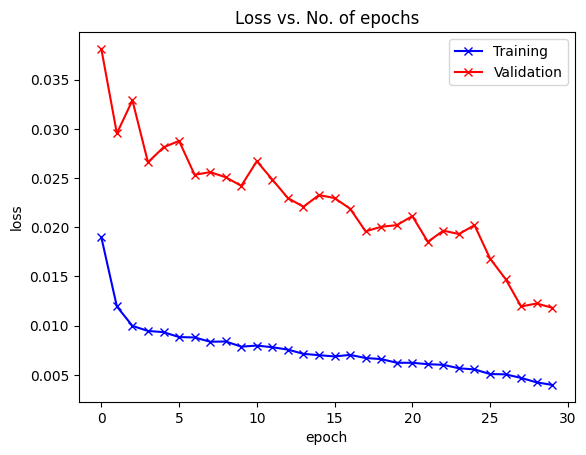

In [65]:
# model selection
model_name = 'bigru'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# scheduler = ExponentialLR(optimizer, gamma=0.95)



bigru_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(bigru_results['train_loss'], bigru_results['val_loss'])

In [116]:
from torchinfo import summary
model = bilstm_results['best_model']
x = torch.randn(1, 1, 74)
out = model(x) # works

summary(model, (1, 1, 74), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [1, 1]                    --
├─LSTM: 1-1                              [1, 1, 1024]              27,607,040
├─Linear: 1-2                            [1, 1]                    1,025
Total params: 27,608,065
Trainable params: 27,608,065
Non-trainable params: 0
Total mult-adds (M): 27.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 110.43
Estimated Total Size (MB): 110.44

## Step 06: Evaluation with Testing Set

### Testing on each experiment

In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'mape' : mean_absolute_percentage_error(df.value, df.prediction),
            }

In [126]:
df_result = {}
df_result['lstm'] = format_predictions(lstm_results['test_pred'], lstm_results['test_actual'], X_test, scaler)
df_result['gru'] = format_predictions(gru_results['test_pred'], gru_results['test_actual'], X_test, scaler)
df_result['bilstm'] = format_predictions(bilstm_results['test_pred'], bilstm_results['test_actual'], X_test, scaler)
df_result['bigru'] = format_predictions(bigru_results['test_pred'], bigru_results['test_actual'], X_test, scaler)
df_result

{'lstm':                value  prediction
 date                            
 2019-01-02  0.002164    0.002769
 2019-01-03 -0.042294   -0.003848
 2019-01-04  0.057206    0.007776
 2019-01-07  0.012081    0.009645
 2019-01-08  0.016825    0.013494
 ...              ...         ...
 2019-12-24 -0.000429    0.004408
 2019-12-26  0.011250    0.005514
 2019-12-27  0.000075    0.004162
 2019-12-30 -0.012748   -0.005670
 2019-12-31  0.006459   -0.003970
 
 [252 rows x 2 columns],
 'gru':                value  prediction
 date                            
 2019-01-02  0.002164    0.006256
 2019-01-03 -0.042294   -0.016011
 2019-01-04  0.057206    0.013985
 2019-01-07  0.012081    0.012449
 2019-01-08  0.016825    0.019187
 ...              ...         ...
 2019-12-24 -0.000429    0.001209
 2019-12-26  0.011250    0.005873
 2019-12-27  0.000075    0.001934
 2019-12-30 -0.012748   -0.010387
 2019-12-31  0.006459   -0.005059
 
 [252 rows x 2 columns],
 'bilstm':                value  prediction
 da

In [128]:
result_metrics = {}
result_metrics['lstm']  = calculate_metrics(df_result['lstm'])
result_metrics['gru']  = calculate_metrics(df_result['gru'])
result_metrics['bilstm']  = calculate_metrics(df_result['bilstm'])
result_metrics['bigru']  = calculate_metrics(df_result['bigru'])

result_metrics['lstm180']  = calculate_metrics(df_result['lstm'][:180])
result_metrics['gru180']  = calculate_metrics(df_result['gru'][:180])
result_metrics['bilstm180']  = calculate_metrics(df_result['bilstm'][:180])
result_metrics['bigru180']  = calculate_metrics(df_result['bigru'][:180])

result_metrics['lstm60']  = calculate_metrics(df_result['lstm'][:60])
result_metrics['gru60']  = calculate_metrics(df_result['gru'][:60])
result_metrics['bilstm60']  = calculate_metrics(df_result['bilstm'][:60])
result_metrics['bigru60']  = calculate_metrics(df_result['bigru'][:60])


In [129]:
pd.DataFrame(result_metrics)

,lstm,gru,bilstm,bigru,lstm180,gru180,bilstm180,bigru180,lstm60,gru60,bilstm60,bigru60
mae,0.009704,0.008890,0.009628,0.006906,0.010443,0.009434,0.010358,0.007396,0.010275,0.010428,0.010235,0.007885
rmse,0.013331,0.011696,0.013231,0.009232,0.014370,0.012470,0.014267,0.009921,0.014480,0.013705,0.014426,0.010601
mape,3.078058,3.758930,3.105413,2.910157,3.176823,3.338180,3.182452,2.692637,2.375073,2.817786,2.370121,2.285269


### visualize the results

In [152]:
def plot_predictions(df_result, show_all = False, dataset = df):
    data = []
    
    if  show_all == True:
        value = go.Scatter(
            x=dataset.index,
            y=dataset.value,
            mode="lines",
            name="values",
            marker=dict(),
            text=dataset.index,
            line=dict(color="rgba(0,0,0, 0.3)"),
        )
        data.append(value)
    
    for dict_key, dict_val in df_result.items():
        if dict_key == 'bigru':
            prediction = go.Scatter(
                x=dict_val.index,
                y=dict_val.prediction,
                mode="lines",
                line={"dash": "solid","color":"red"},
                name=f'model {dict_key}',
                marker=dict(),
                text=dict_val.index,
                opacity=0.8,
            )
        elif dict_key == 'bilstm': 
            prediction = go.Scatter(
                x=dict_val.index,
                y=dict_val.prediction,
                mode="lines",
                line={"dash": "solid","color":"blue"},
                name=f'model {dict_key}',
                marker=dict(),
                text=dict_val.index,
                opacity=0.6,
            )
        else:
            prediction = go.Scatter(
                x=dict_val.index,
                y=dict_val.prediction,
                mode="lines",
                line={"dash": "dot"},
                name=f'model {dict_key}',
                marker=dict(),
                text=dict_val.index,
                opacity=0.8,
            )
        data.append(prediction)
    
    layout = dict(
        # title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Residual Price", ticklen=5, zeroline=True, range=[0, 'auto']),
        margin=dict(l=40, r=40, t=40, b=40),
        width = 1000
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [153]:
filter_df = df[(df.index.year >= 2019) & (df.index.year <= 2019)]
# df_result= None
plot_predictions(df_result,True,filter_df)

check
check
